In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
# data import
data = pd.read_csv("./mushroom/agaricus-lepiota.data", sep=",",  header=None)
cols = ["poisonous", "cap-shape", "cap-surface", "cap-color", "bruises", "odor", "gill-attachment", "gill-spacing",
           "gill-size", "gill-color", "stalk-shape", "stalk-root", "stalk-surface-above-ring", "stalk-surface-below-ring",
           "stalk-color-above-ring", "stalk-color-below-ring", "veil-type", "veil-color", "ring-number", "ring-type", 
           "spore-print-color", "population", "habitat"]
data.columns = cols
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   poisonous                 8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

     1. cap-shape:                bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s
     2. cap-surface:              fibrous=f,grooves=g,scaly=y,smooth=s
     3. cap-color:                brown=n,buff=b,cinnamon=c,gray=g,green=r, pink=p,purple=u,red=e,white=w,yellow=y
     4. bruises?:                 bruises=t,no=f
     5. odor:                     almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s
     6. gill-attachment:          attached=a,descending=d,free=f,notched=n
     7. gill-spacing:             close=c,crowded=w,distant=d
     8. gill-size:                broad=b,narrow=n
     9. gill-color:               black=k,brown=n,buff=b,chocolate=h,gray=g, green=r,orange=o,pink=p,purple=u,red=e, white=w,yellow=y
    10. stalk-shape:              enlarging=e,tapering=t
    11. stalk-root:               bulbous=b,club=c,cup=u,equal=e, rhizomorphs=z,rooted=r,missing=?
    12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
    13. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
    14. stalk-color-above-ring:   brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y
    15. stalk-color-below-ring:   brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y
    16. veil-type:                partial=p,universal=u
    17. veil-color:               brown=n,orange=o,white=w,yellow=y
    18. ring-number:              none=n,one=o,two=t
    19. ring-type:                cobwebby=c,evanescent=e,flaring=f,large=l, none=n,pendant=p,sheathing=s,zone=z
    20. spore-print-color:        black=k,brown=n,buff=b,chocolate=h,green=r, orange=o,purple=u,white=w,yellow=y
    21. population:               abundant=a,clustered=c,numerous=n, scattered=s,several=v,solitary=y
    22. habitat:                  grasses=g,leaves=l,meadows=m,paths=p, urban=u,waste=w,woods=d

In [3]:
with open("./mushroom/agaricus-lepiota.names") as f:
          for line in f.readlines():
            print(line)

1. Title: Mushroom Database



2. Sources: 

    (a) Mushroom records drawn from The Audubon Society Field Guide to North

        American Mushrooms (1981). G. H. Lincoff (Pres.), New York: Alfred

        A. Knopf

    (b) Donor: Jeff Schlimmer (Jeffrey.Schlimmer@a.gp.cs.cmu.edu)

    (c) Date: 27 April 1987



3. Past Usage:

    1. Schlimmer,J.S. (1987). Concept Acquisition Through Representational

       Adjustment (Technical Report 87-19).  Doctoral disseration, Department

       of Information and Computer Science, University of California, Irvine.

       --- STAGGER: asymptoted to 95% classification accuracy after reviewing

           1000 instances.

    2. Iba,W., Wogulis,J., & Langley,P. (1988).  Trading off Simplicity

       and Coverage in Incremental Concept Learning. In Proceedings of 

       the 5th International Conference on Machine Learning, 73-79.

       Ann Arbor, Michigan: Morgan Kaufmann.  

       -- approximately the same results with their HILLARY algor

There are 4 filters with at least 95% accuracy to classify poisonous mushrooms: 
* odor=NOT(almond.OR.anise.OR.none)
* spore-print-color=green
* odor=none.AND.stalk-surface-below-ring=scaly.AND.stalk-color-above-ring=NOT.brown
* habitat=leaves.AND.cap-color=white or population=clustered.AND.cap_color=white

But the label for poisonous has already been predicted, which can be used to filter out any poisonous mushroom. But this is not a required condition, as the conditions are: 
* Visually appealing
* Pleasingly smelling
* Preferably non-toxic 

So first, the columns that are not relevant for visual appeal, pleasant smell, and toxicity need to be filtered out. 

## Visual appeal exclusion
* odor: The odor of mushrooms is not relevant for the visual appeal, but it will be relevant for the pleasant smell
* gill columns: First, what is a gill. Mushroom gills are the thin, papery structures that hang vertically under the cap. As visual appeal is subjective, the gill attachment, spacing, size, or color will not be considered, as they are barely visible. 
* stalk columns: the stalk, or stem of the mushroom, is a relevant category for visual appeal, as it is a large part of the mushroom
* Veil: Thin membrane that covers the cap and stalk of an immature mushroom. Immature mushrooms are sometimes used in cooking, such as button mushrooms. For the purposes of visual appeal, type and color of the veil will be relevant
* Ring: Ring-like or collar-like structure sometimes found on the stipe of some species of mushrooms. Relevant for visual appeal.
* Spore-print-color: Relevant
* population: irrelevant
* habitat: irrelevant

Conclusion: The columns that will be kept for visual appeal are: 
* cap-shape
* cap-surface
* cap-color
* stalk-shape
* stalk-root
* stalk-surface-above-ring
* stalk-surface-below-ring
* stalk-color-above-ring
* stalk-color-below-ring
* veil-type
* veil-color
* ring-number
* ring-type
* spore-print-color

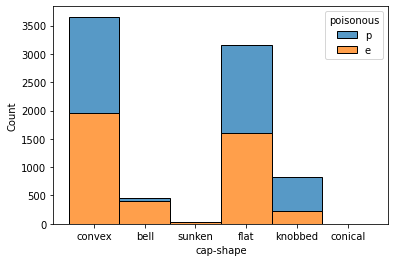

In [4]:
# cap-shape
# bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s
cap_shape = data["cap-shape"].str.replace("b", "bell")
cap_shape = cap_shape.str.replace("c", "conical")
cap_shape = cap_shape.str.replace("x", "convex")
cap_shape = cap_shape.str.replace("f", "flat")
cap_shape = cap_shape.str.replace("k", "knobbed")
cap_shape = cap_shape.str.replace("s", "sunken")

sns.histplot(data=cap_shape, x=cap_shape, hue=data["poisonous"], multiple="stack")
plt.savefig("Cap-shape-poison-distribution.png")

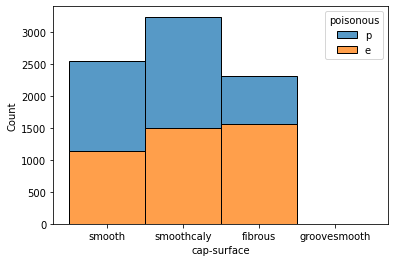

In [5]:
# cap-surface
# fibrous=f,grooves=g,scaly=y,smooth=s
cap_surface = data["cap-surface"].str.replace("g", "grooves")
cap_surface = cap_surface.str.replace("y", "scaly")
cap_surface = cap_surface.str.replace("s", "smooth")
cap_surface = cap_surface.str.replace("f", "fibrous")

sns.histplot(data=cap_surface, x=cap_surface, hue=data["poisonous"], multiple="stack")
plt.savefig("Cap-surface-poison-distribution.png")

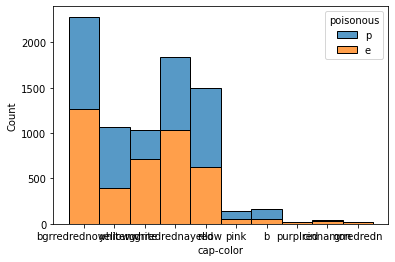

In [6]:
# cap-color
# brown=n,buff=b,cinnamon=c,gray=g,green=r, pink=p,purple=u,red=e,white=w,yellow=y
cap_color = data["cap-color"].str.replace("n", "brown")
cap_color = cap_color.str.replace("c", "cinnamon")
cap_color = cap_color.str.replace("g", "gray")
cap_color = cap_color.str.replace("r", "green")
cap_color = cap_color.str.replace("p", "pink")
cap_color = cap_color.str.replace("u", "purple")
cap_color = cap_color.str.replace("e", "red")
cap_color = cap_color.str.replace("w", "white")
cap_color = cap_color.str.replace("y", "yellow")

sns.histplot(data=cap_color, x=cap_color, hue=data["poisonous"], multiple="stack")
plt.savefig("Cap-color-poison-distribution.png")

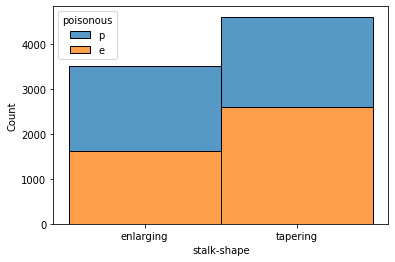

In [7]:
# Stalk-shape
# enlarging = e, tapering = t
stalk_shape = data["stalk-shape"].str.replace("e", "enlarging")
stalk_shape = stalk_shape.str.replace("t", "tapering")

sns.histplot(data=stalk_shape, x=stalk_shape, hue=data["poisonous"], multiple="stack")
plt.savefig("Stalk-shape-poison-distribution.png")

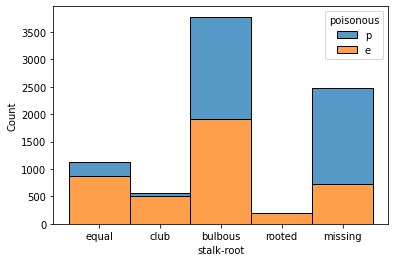

In [8]:
# Stalk-root
# bulbous=b,club=c,cup=u,equal=e, rhizomorphs=z,rooted=r,missing=?
stalk_root = data["stalk-root"].str.replace("b", "bulbous")
stalk_root = stalk_root.str.replace("c", "club")
stalk_root = stalk_root.str.replace("e", "equal")
stalk_root = stalk_root.str.replace("z", "rhizomorphs")
stalk_root = stalk_root.str.replace("r", "rooted")
stalk_root = stalk_root.str.replace("?", "missing")

sns.histplot(data=stalk_root, x=stalk_root, hue=data["poisonous"], multiple="stack")
plt.savefig("Stalk-root-poison-distribution.png")

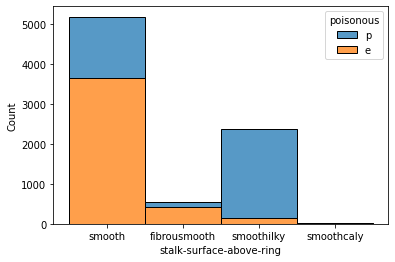

In [9]:
# stalk-surface-above-ring
# fibrous=f,scaly=y,silky=k,smooth=s
stalk_s_a_r = data["stalk-surface-above-ring"].str.replace("f", "fibrous")
stalk_s_a_r = stalk_s_a_r.str.replace("y", "scaly")
stalk_s_a_r = stalk_s_a_r.str.replace("k", "silky")
stalk_s_a_r = stalk_s_a_r.str.replace("s", "smooth")

sns.histplot(data=stalk_s_a_r, x=stalk_s_a_r, hue=data["poisonous"], multiple="stack")
plt.savefig("Stalk-surface-poison-distribution.png")

<Axes: xlabel='stalk-surface-below-ring', ylabel='Count'>

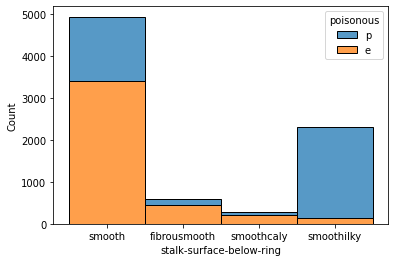

In [10]:
# stalk-surface-below-ring
# fibrous=f,scaly=y,silky=k,smooth=s
stalk_s_b_r = data["stalk-surface-below-ring"].str.replace("f", "fibrous")
stalk_s_b_r = stalk_s_b_r.str.replace("y", "scaly")
stalk_s_b_r = stalk_s_b_r.str.replace("k", "silky")
stalk_s_b_r = stalk_s_b_r.str.replace("s", "smooth")

sns.histplot(data=stalk_s_b_r, x=stalk_s_b_r, hue=data["poisonous"], multiple="stack")

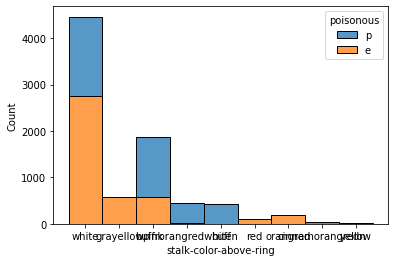

In [11]:
# stalk-color-above-ring
# brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y
stalk_c_a_r = data["stalk-color-above-ring"].str.replace("n", "brown")
stalk_c_a_r = stalk_c_a_r.str.replace("b", "buff")
stalk_c_a_r = stalk_c_a_r.str.replace("c", "cinnamon")
stalk_c_a_r = stalk_c_a_r.str.replace("g", "gray")
stalk_c_a_r = stalk_c_a_r.str.replace("o", "orange")
stalk_c_a_r = stalk_c_a_r.str.replace("p", "pink")
stalk_c_a_r = stalk_c_a_r.str.replace("e", "red")
stalk_c_a_r = stalk_c_a_r.str.replace("w", "white")
stalk_c_a_r = stalk_c_a_r.str.replace("y", "yellow")

sns.histplot(data=stalk_c_a_r, x=stalk_c_a_r, hue=data["poisonous"], multiple="stack")
plt.savefig("Stalk-color-poison-distribution.png")

<Axes: xlabel='stalk-color-below-ring', ylabel='Count'>

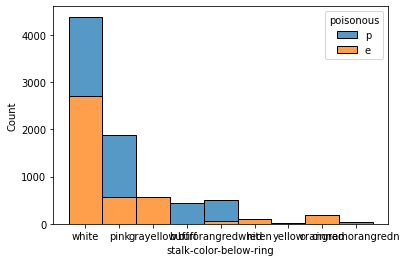

In [12]:
# stalk-color-below-ring
# brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y
stalk_c_b_r = data["stalk-color-below-ring"].str.replace("n", "brown")
stalk_c_b_r = stalk_c_b_r.str.replace("b", "buff")
stalk_c_b_r = stalk_c_b_r.str.replace("c", "cinnamon")
stalk_c_b_r = stalk_c_b_r.str.replace("g", "gray")
stalk_c_b_r = stalk_c_b_r.str.replace("o", "orange")
stalk_c_b_r = stalk_c_b_r.str.replace("p", "pink")
stalk_c_b_r = stalk_c_b_r.str.replace("e", "red")
stalk_c_b_r = stalk_c_b_r.str.replace("w", "white")
stalk_c_b_r = stalk_c_b_r.str.replace("y", "yellow")

sns.histplot(data=stalk_c_b_r, x=stalk_c_b_r, hue=data["poisonous"], multiple="stack")

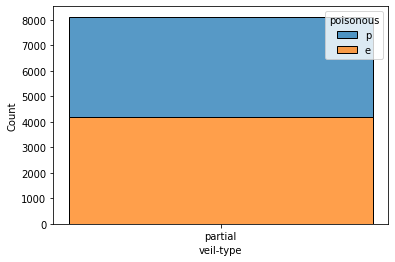

In [13]:
# veil type
# partial=p,universal=u
veil_type = data["veil-type"].str.replace("p", "partial")
veil_type = veil_type.str.replace("u", "universal")

sns.histplot(data=veil_type, x=veil_type, hue=data["poisonous"], multiple="stack")
plt.savefig("Veil-type-poison-distribution.png")

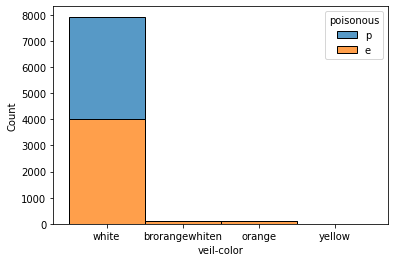

In [14]:
# veil color
# brown=n,orange=o,white=w,yellow=y
veil_color = data["veil-color"].str.replace("n", "brown")
veil_color = veil_color.str.replace("o", "orange")
veil_color = veil_color.str.replace("w", "white")
veil_color = veil_color.str.replace("y", "yellow")

sns.histplot(data=veil_color, x=veil_color, hue=data["poisonous"], multiple="stack")
plt.savefig("Veil-color-poison-distribution.png")

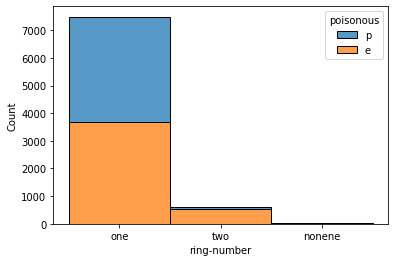

In [15]:
# ring number
# none=n,one=o,two=t
ring_number = data["ring-number"].str.replace("n", "none")
ring_number = ring_number.str.replace("o", "one")
ring_number = ring_number.str.replace("t", "two")

sns.histplot(data=ring_number, x=ring_number, hue=data["poisonous"], multiple="stack")
plt.savefig("Ring-number-poison-distribution.png")

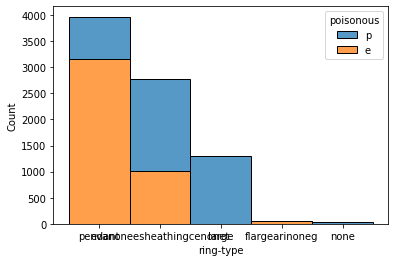

In [16]:
# ring-type
# cobwebby=c,evanescent=e,flaring=f,large=l, none=n,pendant=p,sheathing=s,zone=z
ring_type = data["ring-type"].str.replace("c", "cobwebby")
ring_type = ring_type.str.replace("e", "evanescent")
ring_type = ring_type.str.replace("f", "flaring")
ring_type = ring_type.str.replace("l", "large")
ring_type = ring_type.str.replace("n", "none")
ring_type = ring_type.str.replace("p", "pendant")
ring_type = ring_type.str.replace("s", "sheathing")
ring_type = ring_type.str.replace("z", "zone")

sns.histplot(data=ring_type, x=ring_type, hue=data["poisonous"], multiple="stack")
plt.savefig("Ring-type-poison-distribution.png")

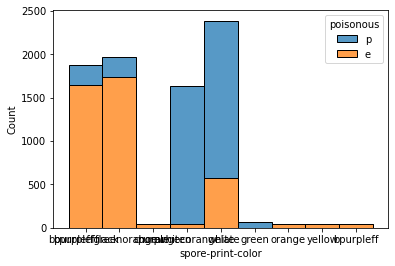

In [17]:
# spore-print-color
# black=k,brown=n,buff=b,chocolate=h,green=r, orange=o,purple=u,white=w,yellow=y
spore_print_color = data["spore-print-color"].str.replace("k", "black")
spore_print_color = spore_print_color.str.replace("n", "brown")
spore_print_color = spore_print_color.str.replace("b", "buff")
spore_print_color = spore_print_color.str.replace("h", "chocolate")
spore_print_color = spore_print_color.str.replace("r", "green")
spore_print_color = spore_print_color.str.replace("o", "orange")
spore_print_color = spore_print_color.str.replace("u", "purple")
spore_print_color = spore_print_color.str.replace("w", "white")
spore_print_color = spore_print_color.str.replace("y", "yellow")

sns.histplot(data=spore_print_color, x=spore_print_color, hue=data["poisonous"], multiple="stack")
plt.savefig("Spore-print-color-poison-distribution.png")

In [18]:
# Now, a manual classification for visually-appealing mushrooms would be helpful in order to see the amount of 
# visually-pleasant mushrooms, as well as determine what is visually pleasant, as it is subjective
data_manual = data.copy()
# cap-shape: bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s
# cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s
# cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r, pink=p,purple=u,red=e,white=w,yellow=y
# Stalk-shape: enlarging = e, tapering = t
# Stalk-root: bulbous=b,club=c,cup=u,equal=e, rhizomorphs=z,rooted=r,missing=?
# stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
# stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
# stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y
# stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y
# veil type: partial=p,universal=u
# veil color: brown=n,orange=o,white=w,yellow=y
# ring number: none=n,one=o,two=t
# ring-type: cobwebby=c,evanescent=e,flaring=f,large=l, none=n,pendant=p,sheathing=s,zone=z
# spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r, orange=o,purple=u,white=w,yellow=y

# First, the characteristics that are visually pleasing must be set: 
# cap-shape: irrelevant
# cap-surface: fibrous surface is not visually pleasant, so it will be filtered out
cap_surface_filter = (data_manual["cap-surface"] != "f")
# cap-color: every color for mushroom cap is visually pleasant
# stalk shape: both possibilities are equally to the eyes of the person performing the test, so no filtering is needed
# stalk-root: cup, rhizomorphs, and rooted are not visually pleasant, so they will be filtered out
stalk_root_filter = (data_manual["stalk-root"] == "u") | (data_manual["stalk-root"] == "z") | (data_manual["stalk-root"] == "r")
# stalk-surface-above-ring and below-ring: A fibrous ring surfacea is not visually pleasant
stalk_surface_ring_filter = (data_manual["stalk-surface-above-ring"] != "f") & (data_manual["stalk-surface-below-ring"] != "f")
# stalk color above and below ring: color of the ring is irrelevant for the visual appeal
# veil type and color: the veil type and color are irrelevant for visual appeal
# ring number: irrelevant
# ring type: cobwebby and sheathing rings are visually unpleasant, so they will be filtered out
ring_type_filter = (data_manual["ring-type"] != "c") & (data_manual["ring-type"] != "s")
# spore-print-color: irrelevant

visual_filter = cap_surface_filter & stalk_root_filter & stalk_surface_ring_filter & ring_type_filter
data_manual["visually-pleasant"] = np.where(visual_filter, 1, 0)
print(data_manual["visually-pleasant"].value_counts())
data_manual[data_manual["visually-pleasant"] == 1].head()

visually-pleasant
0    7932
1     192
Name: count, dtype: int64


,poisonous,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,visually-pleasant
33,e,x,y,n,t,l,f,c,b,p,...,w,w,p,w,o,p,n,y,p,1
41,e,x,y,y,t,l,f,c,b,n,...,w,w,p,w,o,p,k,y,p,1
48,e,x,y,y,t,l,f,c,b,n,...,w,w,p,w,o,p,n,s,p,1
49,e,f,y,y,t,l,f,c,b,w,...,w,w,p,w,o,p,k,s,p,1
50,e,x,y,n,t,a,f,c,b,w,...,w,w,p,w,o,p,k,s,g,1


As it can be seen, based on the filters, which are completely subjective, most mushrooms are NOT visually pleasant. 

## Pleasingly smelling
* odor: It is the only relevant variable for how pleasantly smelling a mushroom is.

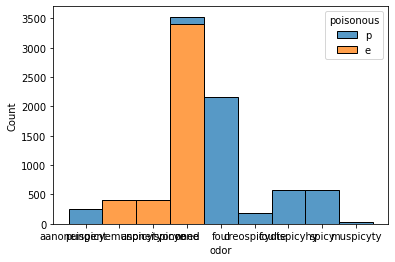

In [19]:
# odor
# almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s
odor = data["odor"].str.replace("a", "almond")
odor = odor.str.replace("l", "anise")
odor = odor.str.replace("c", "creosote")
odor = odor.str.replace("y", "fishy")
odor = odor.str.replace("f", "foul")
odor = odor.str.replace("m", "musty")
odor = odor.str.replace("n", "none")
odor = odor.str.replace("p", "pungent")
odor = odor.str.replace("s", "spicy")

sns.histplot(data=odor, x=odor, hue=data["poisonous"], multiple="stack")
plt.savefig("Odor-poison-distribution.png")

In [20]:
# Now, a manual classification for pleasingly-smelling mushrooms would be helpful in order to see the amount of 
# pleasignly smelling mushrooms
#data_manual = data.copy()
# foul, musty, creosote, and pungent smells are NOT pleasant, in a completely subjective manner. 
# almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s
# therefore, these mushrooms will be filtered out
odor_filter = (data_manual["odor"] != "f") & (data_manual["odor"] != "m") & (data_manual["odor"] != "p") & (data_manual["odor"] != "c")
data_manual["pleasant-smell"] = np.where(odor_filter, 1, 0)
print(data_manual["pleasant-smell"].value_counts())
data_manual[data_manual["pleasant-smell"] == 1].head()

pleasant-smell
1    5480
0    2644
Name: count, dtype: int64


,poisonous,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,visually-pleasant,pleasant-smell
1,e,x,s,y,t,a,f,c,b,k,...,w,p,w,o,p,n,n,g,0,1
2,e,b,s,w,t,l,f,c,b,n,...,w,p,w,o,p,n,n,m,0,1
4,e,x,s,g,f,n,f,w,b,k,...,w,p,w,o,e,n,a,g,0,1
5,e,x,y,y,t,a,f,c,b,n,...,w,p,w,o,p,k,n,g,0,1
6,e,b,s,w,t,a,f,c,b,g,...,w,p,w,o,p,k,n,m,0,1


## Preverably non-toxic
This is relatively objective, as the database predicted the toxicity of mushrooms with some columns with at least a 95% accuracy.
* odor
* spore-print-color
* stalk-surface-below-ring
* stalk-color-above-ring
* habitat
* cap-color

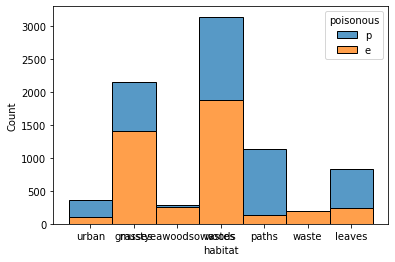

In [21]:
# habitat
# grasses=g,leaves=l,meadows=m,paths=p, urban=u,waste=w,woods=d
habitat = data["habitat"].str.replace("g", "grasses")
habitat = habitat.str.replace("l", "leaves")
habitat = habitat.str.replace("m", "meadows")
habitat = habitat.str.replace("p", "paths")
habitat = habitat.str.replace("u", "urban")
habitat = habitat.str.replace("m", "musty")
habitat = habitat.str.replace("w", "waste")
habitat = habitat.str.replace("d", "woods")

sns.histplot(data=habitat, x=habitat, hue=data["poisonous"], multiple="stack")
plt.savefig("Habitat-poison-distribution.png")

In [22]:
# Filter by poisonous
poison_filter = data_manual["poisonous"] != "p"
data.poisonous.value_counts()

poisonous
e    4208
p    3916
Name: count, dtype: int64

## Combinations
There are a total of 8 combinations:
* visually pleasant, pleasingly smelling, and non-toxic
* visually pleasant, pleasingly smelling, and toxic
* visually pleasant, not pleasingly smelling, and non-toxic
* visually pleasant, not pleasingly smelling, and toxic
* not visually pleasant, pleasingly smelling, and non-toxic
* not visually pleasant, pleasingly smelling, and toxic
* not visually pleasant, not pleasingly smelling, and non-toxic
* not visually pleasant, not pleasingly smelling, and toxic

In [23]:
print("visually pleasant, pleasingly smelling, and non-toxic")
print(len(data_manual[visual_filter & odor_filter & poison_filter]))
print("visually pleasant, pleasingly smelling, and toxic")
print(len(data_manual[visual_filter & odor_filter & ~poison_filter]))
print("visually pleasant, not pleasingly smelling, and non-toxic")
print(len(data_manual[visual_filter & ~odor_filter & poison_filter]))
print("visually pleasant, not pleasingly smelling, and toxic")
print(len(data_manual[visual_filter & ~odor_filter & ~poison_filter]))
print("not visually pleasant, pleasingly smelling, and non-toxic")
print(len(data_manual[~visual_filter & odor_filter & poison_filter]))
print("not visually pleasant, pleasingly smelling, and toxic")
print(len(data_manual[~visual_filter & odor_filter & ~poison_filter]))
print("not visually pleasant, not pleasingly smelling, and non-toxic")
print(len(data_manual[~visual_filter & ~odor_filter & poison_filter]))
print("not visually pleasant, not pleasingly smelling, and toxic")
print(len(data_manual[~visual_filter & ~odor_filter & ~poison_filter]))

visually pleasant, pleasingly smelling, and non-toxic
192
visually pleasant, pleasingly smelling, and toxic
0
visually pleasant, not pleasingly smelling, and non-toxic
0
visually pleasant, not pleasingly smelling, and toxic
0
not visually pleasant, pleasingly smelling, and non-toxic
4016
not visually pleasant, pleasingly smelling, and toxic
1272
not visually pleasant, not pleasingly smelling, and non-toxic
0
not visually pleasant, not pleasingly smelling, and toxic
2644


As it can be seen, out of the database with over 8000 mushrooms samples, there are only 192 that are visually pleasant, pleasingly smelling, and non-toxic. 
It can also be seen that there are no mushrooms that are both visually pleasant and not-pleasingly smelling. 
Around half of the samples is not visually pleasant, but pleasingly smelling and non-toxic

In [24]:
data_manual["poisonous"] = np.where(data_manual["poisonous"] == "p", 1, 0)
data_manual["good_for_stew"] = np.where(visual_filter & odor_filter & poison_filter, 1, 0)
data_manual[data_manual["good_for_stew"] == 1].index

Index([  33,   41,   48,   49,   50,   59,   67,   73,   77,   79,
       ...
       1599, 1672, 1690, 1728, 1744, 1751, 1769, 1915, 2005, 2045],
      dtype='int64', length=192)

With this information, there is now a "truth-table" on which mushrooms are acceptable for the stew. 
This information will be used to compare the different classification techniques too see which one classifies the mushrooms into the 6 correct categories

# Classification algorithms
## KNN (K nearest neighbors)

In [25]:
# As the data is categorical, it needs to be set to one-hot encoded
data_prep = data.copy()
data_prep.head()

,poisonous,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [26]:
x_encoded = pd.get_dummies(data_prep, drop_first = True)
x_encoded.head()
print(x_encoded.head())

   poisonous_p  cap-shape_c  cap-shape_f  cap-shape_k  cap-shape_s  \
0         True        False        False        False        False   
1        False        False        False        False        False   
2        False        False        False        False        False   
3         True        False        False        False        False   
4        False        False        False        False        False   

   cap-shape_x  cap-surface_g  cap-surface_s  cap-surface_y  cap-color_c  ...  \
0         True          False           True          False        False  ...   
1         True          False           True          False        False  ...   
2        False          False           True          False        False  ...   
3         True          False          False           True        False  ...   
4         True          False           True          False        False  ...   

   population_n  population_s  population_v  population_y  habitat_g  \
0         False     

In [27]:
# visually pleasant, pleasingly smelling, and non-toxic
y = data_manual.copy()
y["categories"] = np.NAN
y["categories"] = np.where(visual_filter & odor_filter & poison_filter,"vppsnt", y["categories"])
# visually pleasant, pleasingly smelling, and toxic
y["categories"] = np.where(visual_filter & odor_filter & ~poison_filter,"vppst", y["categories"])
# visually pleasant, not pleasingly smelling, and non-toxic
y["categories"] = np.where(visual_filter & ~odor_filter & poison_filter,"vpnpsnt", y["categories"])
# visually pleasant, not pleasingly smelling, and toxic
y["categories"] = np.where(visual_filter & ~odor_filter & ~poison_filter,"vpnpst", y["categories"])
# not visually pleasant, pleasingly smelling, and non-toxic
y["categories"] = np.where(~visual_filter & odor_filter & poison_filter,"nvppsnt", y["categories"])
# not visually pleasant, pleasingly smelling, and toxic
y["categories"] = np.where(~visual_filter & odor_filter & ~poison_filter,"nvppst", y["categories"])
# not visually pleasant, not pleasingly smelling, and non-toxic
y["categories"] = np.where(~visual_filter & ~odor_filter & poison_filter,"nvpnpsnt", y["categories"])
# not visually pleasant, not pleasingly smelling, and toxic
y["categories"] = np.where(~visual_filter & ~odor_filter & ~poison_filter,"nvpnpst", y["categories"])
y = y["categories"]
#print(y)
#y = data_manual["good_for_stew"].copy()
y_encoded = pd.get_dummies(y, drop_first=True)
y_encoded.info()
y_encoded["nvpnpst"] = np.where((y_encoded["nvppsnt"] == False) & 
                                (y_encoded["nvppst"] == False) &
                                (y_encoded["vppsnt"] == False) , True, False)
print(y_encoded.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   nvppsnt  8124 non-null   bool 
 1   nvppst   8124 non-null   bool 
 2   vppsnt   8124 non-null   bool 
dtypes: bool(3)
memory usage: 23.9 KB
   nvppsnt  nvppst  vppsnt  nvpnpst
0    False   False   False     True
1     True   False   False    False
2     True   False   False    False
3    False   False   False     True
4     True   False   False    False


In [28]:
# Nearest Neighbors Classification
# There are a total of 8 possible types of mushrooms, as previously mentioned
# However, only 4 categories are actually included in the data
knn = KNeighborsClassifier(n_neighbors=4)
#y_encoded = y_encoded.values.ravel()
knn.fit(x_encoded, y_encoded)

KNeighborsClassifier(n_neighbors=4)

In [29]:
pred_res = knn.predict(x_encoded)
comparison = pred_res == y_encoded
print(comparison.head())

   nvppsnt  nvppst  vppsnt  nvpnpst
0     True    True    True     True
1     True    True    True     True
2     True    True    True     True
3     True    True    True     True
4     True    True    True     True


In [30]:
# It can be observed that every mushroom type was clustered correctly
comparison[(comparison["nvppsnt"] == False) &
           (comparison["nvppst"] == False) &
           (comparison["vppsnt"] == False) &
           (comparison["nvpnpst"] == False)].index

Index([], dtype='int64')

However, these predictions were made with Y including only 4 possible categories. 
Results may change if the full categories are added

In [31]:
y_encoded["vpnpsnt"] = False
y_encoded["nvpnpsnt"] = False
y_encoded["vppst"] = False
y_encoded["vpnpst"] = False

In [32]:
knn = KNeighborsClassifier(n_neighbors=8)
#y_encoded = y_encoded.values.ravel()
knn.fit(x_encoded, y_encoded)
pred_res = knn.predict(x_encoded)
comparison = pred_res == y_encoded
print(comparison.head())

   nvppsnt  nvppst  vppsnt  nvpnpst  vpnpsnt  nvpnpsnt  vppst  vpnpst
0     True    True    True     True     True      True   True    True
1     True    True    True     True     True      True   True    True
2     True    True    True     True     True      True   True    True
3     True    True    True     True     True      True   True    True
4     True    True    True     True     True      True   True    True


In [33]:
# It can be observed that every mushroom type was clustered correctly
comparison[(comparison["nvppsnt"] == False) |
           (comparison["nvppst"] == False) |
           (comparison["vppsnt"] == False) |
           (comparison["nvpnpst"] == False) |
          (comparison["vpnpsnt"] == False) |
            (comparison["nvpnpsnt"] == False) |
            (comparison["vppst"] == False) |
            (comparison["vpnpst"] == False)].index

Index([], dtype='int64')

The mushrooms were correctly categorized again, even after including the 8 categories.
However, 4 of those categories include only False values, which may set the algorithm to ignore them completely. 

## Decision Tree

In [34]:
dtc = DecisionTreeClassifier(criterion='entropy',max_depth=10, random_state=42)

In [35]:
dtc.fit(x_encoded, y_encoded)

DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42)

In [36]:
pred_res = dtc.predict(x_encoded)
comparison = pred_res == y_encoded
print(comparison.head())

   nvppsnt  nvppst  vppsnt  nvpnpst  vpnpsnt  nvpnpsnt  vppst  vpnpst
0     True    True    True     True     True      True   True    True
1     True    True    True     True     True      True   True    True
2     True    True    True     True     True      True   True    True
3     True    True    True     True     True      True   True    True
4     True    True    True     True     True      True   True    True


In [37]:
# It can be observed that every mushroom was correctly classified
failed_classifications = comparison[(comparison["nvppsnt"] == False) |
           (comparison["nvppst"] == False) |
           (comparison["vppsnt"] == False) |
           (comparison["nvpnpst"] == False) |
          (comparison["vpnpsnt"] == False) |
            (comparison["nvpnpsnt"] == False) |
            (comparison["vppst"] == False) |
            (comparison["vpnpst"] == False)].index
failed_classifications

Index([], dtype='int64')

In [38]:
data.loc[failed_classifications]

,poisonous,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat


In [39]:
act_res = pd.DataFrame(data=pred_res)
act_res.loc[failed_classifications]

,0,1,2,3,4,5,6,7


In [40]:
y_encoded.loc[failed_classifications]

,nvppsnt,nvppst,vppsnt,nvpnpst,vpnpsnt,nvpnpsnt,vppst,vpnpst


## Logistic Regression

In [41]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

In [42]:
y_logreg = y_encoded.idxmax(1)
logreg.fit(x_encoded, y_logreg)

LogisticRegression(max_iter=1000, multi_class='multinomial')

In [43]:
pred = logreg.predict(x_encoded)

In [44]:
comparison = pred == y_logreg
res = pd.DataFrame()
res["comparison"] = comparison

In [45]:
res.comparison.value_counts()

comparison
True    8124
Name: count, dtype: int64

In [46]:
y_logreg.value_counts()

nvppsnt    4016
nvpnpst    2644
nvppst     1272
vppsnt      192
Name: count, dtype: int64

It can be observed that every single mushroom was correctly predicted. 
However, this is probably due to overfitting, as the model required a maximum iterations value of 1000. 
This could be investigated by splitting the data into training and testing, but that would not be data mining, which is the main purpose of this exploration. 

## Random Forest

In [47]:
clf = RandomForestClassifier(max_depth=10, random_state=0)

In [48]:
clf.fit(x_encoded, y_encoded)

RandomForestClassifier(max_depth=10, random_state=0)

In [49]:
predicted = clf.predict(x_encoded)
print(predicted)

[[False False False ... False False False]
 [ True False False ... False False False]
 [ True False False ... False False False]
 ...
 [ True False False ... False False False]
 [False  True False ... False False False]
 [ True False False ... False False False]]


In [50]:
comparison = predicted == y_encoded

In [51]:
# It can be observed that every mushroom was correctly classified
failed_classifications = comparison[(comparison["nvppsnt"] == False) |
           (comparison["nvppst"] == False) |
           (comparison["vppsnt"] == False) |
           (comparison["nvpnpst"] == False) |
          (comparison["vpnpsnt"] == False) |
            (comparison["nvpnpsnt"] == False) |
            (comparison["vppst"] == False) |
            (comparison["vpnpst"] == False)].index
failed_classifications

Index([], dtype='int64')

In [52]:
y_encoded.loc[failed_classifications]#.value_counts()

,nvppsnt,nvppst,vppsnt,nvpnpst,vpnpsnt,nvpnpsnt,vppst,vpnpst


In [53]:
feature_importance = clf.feature_importances_
feature_names = clf.feature_names_in_
relevance = sorted(zip(feature_importance,feature_names), reverse=True)
for f in relevance:
    print(f)

(0.1702742242947525, 'poisonous_p')
(0.1591993447973365, 'odor_f')
(0.09773135821477551, 'odor_n')
(0.04976043279114092, 'gill-size_n')
(0.03944957506776112, 'odor_s')
(0.0380184776896959, 'spore-print-color_h')
(0.03469387081352068, 'stalk-surface-above-ring_k')
(0.034201521197993044, 'spore-print-color_w')
(0.03131155597509796, 'odor_y')
(0.023992935034329425, 'ring-type_l')
(0.0224520088098572, 'ring-type_p')
(0.01708423195774115, 'stalk-surface-below-ring_y')
(0.016704773169197194, 'stalk-root_r')
(0.01624006271876742, 'stalk-surface-below-ring_s')
(0.01575454315445905, 'bruises_t')
(0.014696124371947868, 'population_v')
(0.01404788511209098, 'stalk-surface-above-ring_s')
(0.013438575601606313, 'stalk-shape_t')
(0.01334410829650737, 'odor_p')
(0.013117411242060643, 'stalk-root_b')
(0.012358472785354908, 'stalk-surface-below-ring_k')
(0.01175246604532633, 'spore-print-color_n')
(0.010325477635889068, 'stalk-root_e')
(0.01031186778309829, 'odor_c')
(0.008272756409826446, 'stalk-root_

## DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

In [54]:
# First, default parameters
dbscan_model = DBSCAN(eps=2.9, min_samples=5)

In [55]:
dbscan_model.fit(x_encoded)

DBSCAN(eps=2.9)

In [56]:
predicted = pd.DataFrame()
predicted["res"] = dbscan_model.labels_
print(predicted.res.value_counts())

res
0    4712
2    1808
1    1296
5     192
3      48
6      36
8      16
4       8
7       8
Name: count, dtype: int64


In [57]:
pred_nvppsnt = predicted[predicted["res"] == 0]
pred_nvpnpst = predicted[predicted["res"] == 2]
pred_nvppst = predicted[predicted["res"] == 1]
pred_vppsnt = predicted[predicted["res"] == 5]

In [58]:
pred_nvppsnt.index.difference(y_encoded["nvppsnt"].index)

Index([], dtype='int64')

In [59]:
y_encoded["nvppsnt"].index.difference(pred_nvppsnt.index)

Index([1816, 2128, 2178, 2238, 2385, 2443, 2533, 2536, 2539, 2566,
       ...
       8114, 8115, 8116, 8117, 8118, 8119, 8120, 8121, 8122, 8123],
      dtype='int64', length=3412)

It can be observed that with an unsupervised clustering algorithm, the errors were too large. 
However, another unsupervised algorithm may work correctly

## K-means

In [60]:
kmeans_model = KMeans(n_clusters=4, random_state=0, n_init="auto")

In [61]:
kmeans_model.fit(x_encoded)

KMeans(n_clusters=4, n_init='auto', random_state=0)

In [62]:
predicted = pd.DataFrame()
predicted["res"] = kmeans_model.predict(x_encoded)
print(predicted.res.value_counts())

res
3    3053
0    1940
1    1835
2    1296
Name: count, dtype: int64


In [63]:
data[predicted["res"] == 3]

,poisonous,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8094,e,b,s,g,f,n,f,w,b,g,...,s,w,w,p,w,t,p,w,n,g
8096,e,k,f,w,f,n,f,w,b,w,...,s,w,w,p,w,t,p,w,n,g
8099,e,k,f,w,f,n,f,w,b,w,...,k,w,w,p,w,t,p,w,s,g
8109,e,b,s,w,f,n,f,w,b,w,...,s,w,w,p,w,t,p,w,n,g


Once again, it can be observed that the unsupervised algorithm did not perform the classification as expected, as it mixed different types of mushrooms, such as including both poisonous and not poisonous mushrooms, including both nice smelling and not nice smelling mushrooms, etc. 

https://datascienceplus.com/mushrooms-classification-part-1/
https://datascienceplus.com/mushrooms-classification-part-2/
https://datarepository.wolframcloud.com/resources/Sample-Data-Mushroom-Classification
https://data-flair.training/blogs/machine-learning-classification-algorithms/
https://archive.ics.uci.edu/dataset/73/mushroom
https://12ft.io/
